In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Sum,Recall,Accuracy,Precision,mape,AUC
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.layers import Flatten,add
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.debugging.set_log_device_placement(True)
import Preloader
import Model
import utils

In [2]:
x_train, x_val, x_test, y_train, y_val, y_test = Preloader.direct_load(path="C:/Om/Data",sample=2000)


spliting data███████████████████████████████████████████████████████████████████████████████████████ 100% 2000/2000 creating_binary_masks


In [3]:
batch_size =32
gt,gtest,gval = Preloader.augment(x_train, x_val, x_test, y_train, y_val, y_test,batch_size)

In [31]:
def yolo_v2_model(input_shape=(256,256,3)):
    input = Input(input_shape)

    def blocks(x,filters:int,block_no:int,max:int=1):
        y= Conv2D ( filters,(3,3),strides = (1,1),padding='same',name=f'conv{block_no}_1')(x)
        y= BatchNormalization(name=f"bnorm{block_no}")(y)
        y=Activation('relu')(y)
        if max:
            y= MaxPooling2D(pool_size=(2,2),name=f"maxpool{block_no}")(y)
        return y

    x = blocks(input,64,2)      #block 1
    x = blocks(x,128,3)     #block 2
    x = blocks(x,256,4)     #block 3
    x = blocks(x,512,5)     #block 4
    x = blocks(x,1024,6,max=0)    #block 5

    x = Conv2D(1,(3,3),strides=(1,1),padding='same',name="output_conv")(x)
    output = Flatten(name="output")(x)

    model = tf.keras.Model(inputs=[input], outputs=[output])
    model.summary()
    return model


In [35]:
model = Model.Unet1()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 256, 256, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_96[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_97[0][0]                  
____________________________________________________________________________________________

In [ ]:
with tf.device('/GPU:0'):
    model = Model.yolo_v2_model()
    #model.compile(optimizer = Adam(), loss = [dice_loss,'binary_crossentropy','hinge'] ,metrics = (Accuracy,AUC,Recall,Precision))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=[dice_loss, 'binary_crossentropy', 'hinge'], metrics=[Accuracy(), AUC(), Recall(), Precision()])

    history = model.fit(gt,epochs=50,verbose=1,validation_data=gval,callbacks = [checkpoint])#,early_stop,reducelr])

In [39]:
checkpoints=utils.Checkpoints("UNet2")
with tf.device('/GPU:0'):
    model = Model.Unet1()
    #model.compile(optimizer = Adam(), loss = [dice_loss,'binary_crossentropy','hinge'] ,metrics = (Accuracy,AUC,Recall,Precision))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=utils.dice_loss)

    history = model.fit(gt,epochs=50,verbose=1,validation_data=gval,callbacks = [checkpoints])#,early_stop,reducelr])

AttributeError: module 'utils' has no attribute 'Checkpoints'

In [15]:
#Load 
from Model import unet
model = unet()
model.load_weights("Checkpoints\Model1\Model1.cpkt")

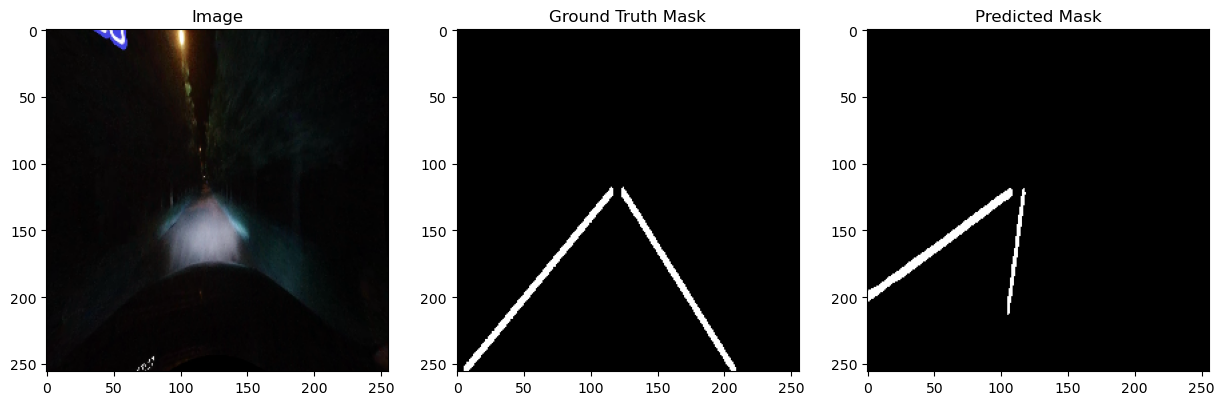

In [30]:
test_gen = gtest

# Get one batch of test data
x_test, y_test = test_gen.next()

# Get the model prediction for the first image in the batch
pred = model.predict(x_test[31].reshape(1, 256, 256, 3))

# Convert the predicted mask to binary
pred_mask = (pred > 0.5).astype(np.uint8)[0]

# Visualize the image, ground truth mask, and predicted mask
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x_test[0]*255)
axs[0].set_title('Image')

axs[1].imshow(y_test[0, :, :, 0], cmap='gray')
axs[1].set_title('Ground Truth Mask')

axs[2].imshow(pred_mask[:, :, 0], cmap='gray')
axs[2].set_title('Predicted Mask')

plt.show()